In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, Model, model_from_json
from app import *
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop, Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score

Using TensorFlow backend.


In [18]:
df = pd.read_csv('train10K.csv')
df = df[df['amount'] >0]

train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

y_train = train_set[["label"]].copy()
X_train = train_set.drop(["approved","amount","label"],axis=1)
X_train = X_train.values.astype(np.float32)
y_train = y_train.values.reshape(-1)

y_test = test_set[["label"]].copy()
y_test = y_test.values.reshape(-1)
X_test = test_set.drop(["approved","amount","label"],axis=1)
X_test = X_test.values.astype(np.float32)

X_valid, X_train = X_train[:1000], X_train[1000:]
y_valid, y_train = y_train[:1000], y_train[1000:]

In [65]:
from keras.utils import to_categorical

#one-hot encode target column
y_train_b = to_categorical(y_train)
y_valid_b = to_categorical(y_valid)

In [44]:
def clf_model():
    model = Sequential()
    model.add(Dense(100, input_dim=8, kernel_initializer='normal',activation='relu'))
    model.add(Dense(50,kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [43]:
def regression_model(EPOCHS, INIT_LR):
    inputs = Input(shape=(8,))
    x = Dense(300, kernel_initializer='normal',activation='relu')(inputs)
    x = Dense(150,kernel_initializer='normal',activation='relu')(x)
    y = Dense(10, activation='sigmoid')(x)
    
    model = Model(inputs=inputs,outputs=y)
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [30]:
seed = 7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=clf_model,epochs=50,batch_size=50,verbose=0)

In [6]:
kfold = KFold(n_splits=5, random_state=seed)
result = cross_val_score(estimator,X_train,y_train,cv=kfold)
scores = np.sqrt(-result)

In [7]:
def score_show(scores):
    print("Score: ",scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [9]:
score_show(result)

Score:  [-0.02920458 -0.00394147 -0.00739842 -0.00449282 -0.00421797]
Mean:  -0.00985105163427
Standard Deviation:  0.00975643138532


In [46]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
model = regression_model(EPOCHS, INIT_LR)
history = model.fit(X_train, y_train_b, epochs=EPOCHS,batch_size=BS,validation_split=0.2)

Train on 6000 samples, validate on 1500 samples
Epoch 1/20
6000/6000 [==============================] - 3s 511us/step - loss: 0.2198 - acc: 0.9240 - val_loss: 0.1623 - val_acc: 0.9349
Epoch 2/20
6000/6000 [==============================] - 1s 166us/step - loss: 0.1351 - acc: 0.9446 - val_loss: 0.1091 - val_acc: 0.9535
Epoch 3/20
6000/6000 [==============================] - 1s 166us/step - loss: 0.1032 - acc: 0.9548 - val_loss: 0.0961 - val_acc: 0.9598
Epoch 4/20
6000/6000 [==============================] - 1s 160us/step - loss: 0.0894 - acc: 0.9611 - val_loss: 0.0801 - val_acc: 0.9653
Epoch 5/20
6000/6000 [==============================] - 1s 158us/step - loss: 0.0770 - acc: 0.9666 - val_loss: 0.0764 - val_acc: 0.9689
Epoch 6/20
6000/6000 [==============================] - 1s 158us/step - loss: 0.0654 - acc: 0.9727 - val_loss: 0.0686 - val_acc: 0.9697
Epoch 7/20
6000/6000 [==============================] - 1s 159us/step - loss: 0.0576 - acc: 0.9761 - val_loss: 0.0525 - val_acc: 0.9803


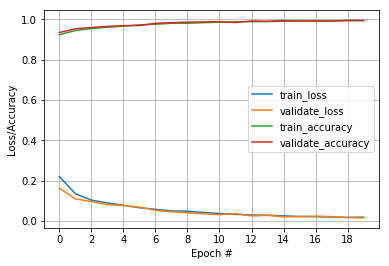

In [62]:
fig = plt.figure()
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='validate_loss')
plt.plot(history.history['acc'],label='train_accuracy')
plt.plot(history.history['val_acc'],label='validate_accuracy')
plt.xticks(np.arange(0, 20, step=2))
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.grid(True)
plt.xlabel('Epoch #')
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('cont.jpg')
plt.show()

In [99]:
y_pred = model.predict(X_valid)

In [100]:
y_pred = [np.argmax(i) for i in y_pred] 

In [102]:
model.evaluate(X_valid,y_valid_b,verbose=0)

[0.016582960650324823, 0.9945999927520752]

In [103]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")   

Saved model to disk


In [2]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

df = pd.read_csv('test5K.csv')

y = df[["label"]].copy()
y = y.values.reshape(-1)

X = df.drop(["approved", "amount", "label"], axis=1)
X = X.values.astype(np.float32)

y_pred = model.predict(X)
y_pred = [np.argmax(i) for i in y_pred]

print(accuracy_score(y,y_pred))

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


155.87774464369173

In [20]:
confusion_matrix(y,y_pred)

array([[2004,    1,    8,    0,    6,    6,    3,    2,    1],
       [   5,  410,    3,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1074,    0,    0,    0,    0,    0,    0],
       [   1,    0,    0,  261,    6,    0,    0,    0,    0],
       [   1,    0,    0,   11,  450,   17,    0,    0,    0],
       [   2,    0,    0,    0,    0,  394,    0,    0,    0],
       [   2,    0,    0,    0,    0,    6,  168,    0,    0],
       [   3,    0,    0,    0,    0,    0,    0,   74,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,   79]],
      dtype=int64)

In [28]:
def result(y_amount_bug):
    y_bug = [label(i) for i in y_amount_bug]
    
    bug_real = [i == j for i, j in zip(y, y_bug)]
    bug_pred = [compare(i, j, 0.05, 0.95) for i, j in zip(y_pred, y_bug)]

    cm = confusion_matrix(bug_real,bug_pred)
    print(cm)
    row_sums = cm.sum(axis=1, keepdims=True)
    norm = cm/row_sums

    a = norm[0][1]*100
    b = norm[1][0]*100
    c = 100*(cm[0][2]+cm[1][2])/5000
    print("{0:.2f}  {1:.2f}, {2:.2f}".format(a, b, c))    

In [29]:
y_amount_bug = [credit_approval_bug_21(*s.astype(np.int64))[1] for s in X]
y_bug = [label(i) for i in y_amount_bug]
result(y_amount_bug)

[[   0    3  104]
 [   0 4811   82]
 [   0    0    0]]
2.80  0.00, 3.72


C:\Users\thanh\Miniconda3\envs\datasci\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [8]:
y_amount_bug = [credit_approval_bug_1(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_2(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_3(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_4(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_5(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_6(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_7(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_8(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_9(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_10(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_11(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_12(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_13(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_14(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_15(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_16(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_17(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_18(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_19(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_20(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)
y_amount_bug = [credit_approval_bug_21(*s.astype(np.int64))[1] for s in X]
result(y_amount_bug)

C:\Users\thanh\Miniconda3\envs\datasci\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


15.58  0.02, 10.22
14.73  0.03, 20.60
14.67  0.03, 19.12
14.49  0.04, 38.90
15.17  0.00, 58.62
16.48  0.02, 4.98
0.10  0.05, 59.82
48.00  0.03, 15.86
47.85  0.02, 2.26
53.67  0.02, 3.44
52.74  0.02, 3.32
56.20  0.02, 5.70
99.63  0.02, 0.68
100.00  0.02, 0.68
100.00  0.02, 0.68
100.00  0.02, 0.68
99.17  0.02, 0.70
100.00  0.02, 0.68
100.00  0.02, 0.68
100.00  0.02, 0.68
99.07  0.02, 0.70
